## Introduction

Text Classification can be used to solve various use-cases like sentiment analysis, spam detection, hashtag prediction etc. This notebook demonstrates the use of SageMaker BlazingText to perform supervised binary/multi class with single or multi label text classification. BlazingText can train the model on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algorithms. BlazingText extends the fastText text classifier to leverage GPU acceleration using custom CUDA kernels.

## Setup

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [1]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()
print(
    role
)  # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

region = boto3.Session().region_name

bucket = sess.default_bucket()  # Replace with your own bucket name if needed
print(bucket)
prefix = "blazingtext/supervised"  # Replace with the prefix under which you want to store the data if needed

data_bucket = "fnandito-ml-sentiment-data"  # Replace with the bucket where your data is located
data_prefix = "LabelledData"

arn:aws:iam::930652504693:role/service-role/AmazonSageMaker-ExecutionRole-20210608T154827
sagemaker-ap-southeast-1-930652504693


### Data Engineering

First, let's take a look at our data. We'll use the data from S3 bucket we have uploaded

In [2]:
FileName = "IndonesianTweetLabelled"
DataLocation = data_prefix+"/"+FileName

s3_client = boto3.client("s3")
s3_client.download_file(Bucket=data_bucket, Key=DataLocation, Filename=FileName) #Download S3 file to local

In [3]:
import pandas as pd

Data = pd.read_csv(FileName, sep='\t', header=0)
Data.head(5)

,sentimen,Tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...


BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence and the corresponding label(s) prefixed by "\___label\___".

In [4]:
PositiveData = []
NeutralData = []
NegativeData = []

for index, row in Data.iterrows():
    if row['sentimen'] == 1:
        PositiveData.append("__label__Positive " + row['Tweet'])
    elif row['sentimen'] == 0:
        NeutralData.append("__label__Neutral " + row['Tweet'])
    elif row['sentimen'] == -1:
        NegativeData.append("__label__Negative " + row['Tweet'])
    else:
        print("Mislabelled data detected on index" + index)

Let's see how much the data we have for each of the label

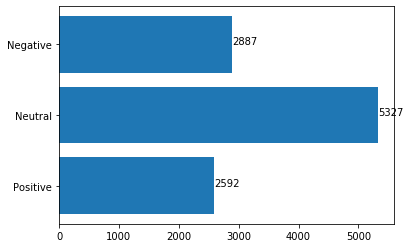

In [5]:
import matplotlib.pyplot as plt
LabelName = ['Positive', 'Neutral', 'Negative']
TotalLabel = [len(PositiveData), len(NeutralData), len(NegativeData)]
plt.barh(LabelName, TotalLabel)
  
for index, value in enumerate(TotalLabel):
    plt.text(value, index,
             str(value))
  
plt.show()

Write your file and upload to S3 so it can be recognized by the algorithm. Need to split the data as well. To split it, We are going to use 80-20 split. Since we have splitted it based on labels, we are going to split the label, and merge it into 1.

In [6]:
import random
import numpy as np

random.shuffle(PositiveData)
random.shuffle(NeutralData)
random.shuffle(NegativeData)

PositiveNArr = np.array(PositiveData)
NeutralNArr = np.array(NeutralData)
NegativeNArr = np.array(NegativeData)

In [7]:
PositiveTrain = PositiveNArr[:int(len(PositiveNArr)*0.8)]
PositiveTest = PositiveNArr[-int(len(PositiveNArr)*0.2):]
NeutralTrain = NeutralNArr[:int(len(NeutralNArr)*0.8)]
NeutralTest = NeutralNArr[-int(len(NeutralNArr)*0.2):]
NegativeTrain = NegativeNArr[:int(len(NegativeNArr)*0.8)]
NegativeTest = NegativeNArr[-int(len(NegativeNArr)*0.2):]

In [8]:
TrainData = np.array(PositiveTrain)
TrainData = np.append(TrainData, NeutralTrain)
TrainData = np.append(TrainData, NegativeTrain)

TestData = np.array(PositiveTest)
TestData = np.append(TestData, NeutralTest)
TestData = np.append(TestData, NegativeTest)

Now, we need to save the train and test to S3 that is being used for sagemaker, so it can be accessed by the model

In [9]:
from datetime import datetime
from numpy import savetxt

now = datetime.now()
timestamp = now.strftime("%d-%m-%Y-%H:%M:%S")

TrainFileName = "TrainData-" + timestamp
TestFileName = "TestData-" + timestamp

np.savetxt(TrainFileName, TrainData , fmt='%s')
np.savetxt(TestFileName, TestData, fmt='%s')

In [10]:
prefix = "FormattedData/SentimentAnalysis"
train_channel = prefix + "/train"
validation_channel = prefix + "/validation"

sess.upload_data(path=TrainFileName, bucket=bucket, key_prefix=train_channel)
sess.upload_data(path=TestFileName, bucket=bucket, key_prefix=validation_channel)

s3_train_data = "s3://{}/{}".format(bucket, train_channel)
s3_validation_data = "s3://{}/{}".format(bucket, validation_channel)
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)

In [11]:
import os

os.remove(TrainFileName)
os.remove(TestFileName)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [12]:
region_name = boto3.Session().region_name

In [13]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print("Using SageMaker BlazingText container: {} ({})".format(container, region_name))

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Using SageMaker BlazingText container: 475088953585.dkr.ecr.ap-southeast-1.amazonaws.com/blazingtext:1 (ap-southeast-1)


## Training the BlazingText model for supervised text classification

Similar to the original implementation of [Word2Vec](https://arxiv.org/pdf/1301.3781.pdf), SageMaker BlazingText provides an efficient implementation of the continuous bag-of-words (CBOW) and skip-gram architectures using Negative Sampling, on CPUs and additionally on GPU[s]. The GPU implementation uses highly optimized CUDA kernels. To learn more, please refer to [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354).




Besides skip-gram and CBOW, SageMaker BlazingText also supports the "Batch Skipgram" mode, which uses efficient mini-batching and matrix-matrix operations ([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)). This mode enables distributed word2vec training across multiple CPU nodes, allowing almost linear scale up of word2vec computation to process hundreds of millions of words per second. Please refer to [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf) to learn more.

BlazingText also supports a *supervised* mode for text classification. It extends the FastText text classifier to leverage GPU acceleration using custom CUDA kernels. The model can be trained on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algorithms. For more information, please refer to the [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html).

To summarize, the following modes are supported by BlazingText on different types instances:

|          Modes         	| cbow (supports subwords training) 	| skipgram (supports subwords training) 	| batch_skipgram 	| supervised |
|:----------------------:	|:----:	|:--------:	|:--------------:	| :--------------:	|
|   Single CPU instance  	|   ✔  	|     ✔    	|        ✔       	|  ✔  |
|   Single GPU instance  	|   ✔  	|     ✔    	|                	|  ✔ (Instance with 1 GPU only)  |
| Multiple CPU instances 	|      	|          	|        ✔       	|     | |

Now, let's define the SageMaker `Estimator` with resource configurations and hyperparameters to train Text Classification on *DBPedia* dataset, using "supervised" mode on a `c4.4xlarge` instance.

Refer to [BlazingText Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) in the Amazon SageMaker documentation for the complete list of hyperparameters.

In [14]:
bt_model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.4xlarge",
    volume_size=35,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    hyperparameters={
        "mode": "supervised",
        "epochs": 5,
        "min_count": 2,
        "learning_rate": 0.1,
        "vector_dim": 10,
        "early_stopping": True,
        "patience": 4,
        "min_epochs": 5,
        "word_ngrams": 3,
    },
)

Now that the hyper-parameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [15]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

We have our `Estimator` object, we have set the hyper-parameters for this object and we have our data channels linked with the algorithm. The only  remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instance that we requested while creating the `Estimator` classes is provisioned and is setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take some time, depending on the size of the data. Therefore it might be a few minutes before we start getting training logs for our training jobs. The data logs will also print out Accuracy on the validation data for every epoch after training job has executed `min_epochs`. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [16]:
bt_model.fit(inputs=data_channels, logs=True)

2021-07-12 06:00:48 Starting - Starting the training job...
2021-07-12 06:00:50 Starting - Launching requested ML instancesProfilerReport-1626069648: InProgress
......
2021-07-12 06:02:15 Starting - Preparing the instances for training......
2021-07-12 06:03:15 Downloading - Downloading input data...
2021-07-12 06:03:45 Training - Training image download completed. Training in progress.
2021-07-12 06:03:45 Uploading - Uploading generated training modelArguments: train
[07/12/2021 06:03:35 WARNING 140066778305920] Loggers have already been setup.
[07/12/2021 06:03:35 WARNING 140066778305920] Loggers have already been setup.
[07/12/2021 06:03:35 INFO 140066778305920] nvidia-smi took: 0.02518773078918457 secs to identify 0 gpus
[07/12/2021 06:03:35 INFO 140066778305920] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[07/12/2021 06:03:35 INFO 140066778305920] 6 files found in train channel. Using /opt/ml/input/data/train

## Hosting / Inference
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train. Because instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

In [17]:
from sagemaker.serializers import JSONSerializer

text_classifier = bt_model.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=JSONSerializer()
)

--------------!

#### Use JSON format for inference
BlazingText supports `application/json` as the content-type for inference. The payload should contain a list of sentences with the key as "**instances**" while being passed to the endpoint.

In [39]:
import nltk

sentences = [
    "saya bahagia dan senang atas kerja keras anda",
    "saya ragu dalam mengambil keputusan",
    "Saya tidak setuju dengan pendapat anda",
]

# using the same nltk tokenizer that we used during data preparation for training
tokenized_sentences = [" ".join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances": tokenized_sentences}

response = text_classifier.predict(payload)

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "label": [
      "__label__Positive"
    ],
    "prob": [
      0.38888469338417053
    ]
  },
  {
    "label": [
      "__label__Neutral"
    ],
    "prob": [
      0.7176376581192017
    ]
  },
  {
    "label": [
      "__label__Negative"
    ],
    "prob": [
      0.4486387372016907
    ]
  }
]


By default, the model will return only one prediction, the one with the highest probability. For retrieving the top k predictions, you can set `k` in the configuration as shown below:

In [40]:
payload = {"instances": tokenized_sentences, "configuration": {"k": 2}}

response = text_classifier.predict(payload)

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "label": [
      "__label__Positive",
      "__label__Negative"
    ],
    "prob": [
      0.38888469338417053,
      0.3500923216342926
    ]
  },
  {
    "label": [
      "__label__Neutral",
      "__label__Negative"
    ],
    "prob": [
      0.7176376581192017,
      0.14643968641757965
    ]
  },
  {
    "label": [
      "__label__Negative",
      "__label__Positive"
    ],
    "prob": [
      0.4486387372016907,
      0.3628771901130676
    ]
  }
]


## Hyperparameter Optimization (HPO)
*Note, with the default settings below, the hyperparameter tuning job can take up to ~20 minutes to complete.*

We will use SageMaker HyperParameter Optimization (HPO) to automate the searching process effectively. Specifically, we **specify a range**, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune.

In [20]:
# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter
)

# set up hyperparameter ranges
ranges = {
    #"mode": CategoricalParameter("supervised"),
    "epochs": IntegerParameter(1, 5),
    "learning_rate": ContinuousParameter(0.01, 0.2),
    "min_count": IntegerParameter(1, 5),
    "word_ngrams": IntegerParameter(1, 3),
}

# set up the objective metric
objective = "validation:accuracy"

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=bt_model,  # the SageMaker estimator object
    hyperparameter_ranges=ranges,  # the range of hyperparameters
    max_jobs=10,  # total number of HPO jobs
    max_parallel_jobs=5,  # how many HPO jobs can run in parallel
    strategy="Bayesian",  # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",  # maximize or minimize the objective metric
)

In [21]:
# start HPO
tuner.fit(data_channels)

..........................................................................................!


## Deploy HPO Model

In [44]:
# deploy the best model from HPO
hpo_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=JSONSerializer()
)


2021-07-12 06:18:49 Starting - Preparing the instances for training
2021-07-12 06:18:49 Downloading - Downloading input data
2021-07-12 06:18:49 Training - Training image download completed. Training in progress.
2021-07-12 06:18:49 Uploading - Uploading generated training model
2021-07-12 06:18:49 Completed - Training job completed
-------------!

In [45]:
sentences = [
    "saya bahagia dan senang atas kerja keras anda",
    "saya ragu dalam mengambil keputusan",
    "Saya tidak setuju dengan pendapat anda",
]

# using the same nltk tokenizer that we used during data preparation for training
tokenized_sentences = [" ".join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances": tokenized_sentences}

response = hpo_predictor.predict(payload)

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))
print(tokenized_sentences)

[
  {
    "label": [
      "__label__Positive"
    ],
    "prob": [
      0.6487286686897278
    ]
  },
  {
    "label": [
      "__label__Neutral"
    ],
    "prob": [
      0.9901147484779358
    ]
  },
  {
    "label": [
      "__label__Negative"
    ],
    "prob": [
      0.7845661640167236
    ]
  }
]
['saya bahagia dan senang atas kerja keras anda', 'saya ragu dalam mengambil keputusan', 'Saya tidak setuju dengan pendapat anda']


In [46]:
payload = {"instances": tokenized_sentences, "configuration": {"k": 2}}

response = hpo_predictor.predict(payload)

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "label": [
      "__label__Positive",
      "__label__Negative"
    ],
    "prob": [
      0.6487286686897278,
      0.3419760763645172
    ]
  },
  {
    "label": [
      "__label__Neutral",
      "__label__Positive"
    ],
    "prob": [
      0.9901147484779358,
      0.005970051046460867
    ]
  },
  {
    "label": [
      "__label__Negative",
      "__label__Positive"
    ],
    "prob": [
      0.7845661640167236,
      0.15173567831516266
    ]
  }
]


### Stop / Close the Endpoint (Optional)
Finally, we should delete the endpoint before we close the notebook if we don't need to keep the endpoint running for serving realtime predictions.

In [47]:
sess.delete_endpoint(text_classifier.endpoint)
sess.delete_endpoint(hpo_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
